<a href="https://colab.research.google.com/github/afaale/ML/blob/ML/Mnist_nums_numpy_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Attempt at predicting 28*28 px handwritten digits without tensorflow or keras, apart from loading the mnist dataset. The guide I followed is 
https://towardsdatascience.com/mnist-handwritten-digits-classification-from-scratch-using-python-numpy-b08e401c4dab

In [4]:
from keras.datasets import mnist
import numpy as np
from matplotlib import pyplot as plt
import keras

In [5]:
(X_train,y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [6]:
#Validation split
rand = np.arange(60000)
#np.random.shuffle(rand)

train_num = rand[:50000]
val_num = rand[50000:]

X_train, X_val = X_train[train_num], X_train[val_num]
y_train, y_val = y_train[train_num], y_train[val_num]
X_train.shape,X_val.shape,y_test.shape, y_val.shape


((50000, 28, 28), (10000, 28, 28), (10000,), (10000,))

In [7]:
def init(x,y):
    #initialize weight matrices
    layer = np.random.uniform(-1,1, size=(x,y))/np.sqrt(x*y)
    return layer.astype(np.float32)

l1 = init(28*28, 128)
l2 = init(128, 10)
l1

array([[-1.0697895e-03,  1.1405038e-04, -2.5644854e-03, ...,
        -2.9394235e-03, -1.8240644e-03, -1.7526557e-03],
       [-6.5442349e-05, -1.8304684e-03,  1.4367673e-03, ...,
        -1.2803435e-03,  1.7942283e-03, -2.7872690e-03],
       [ 5.8182178e-04,  2.3616131e-03,  6.5780513e-04, ...,
        -8.4398547e-04, -3.8834251e-04, -1.1745419e-03],
       ...,
       [ 1.7910042e-03,  2.9611643e-03, -2.6786565e-03, ...,
        -2.9991248e-03, -7.9321401e-04, -1.4099642e-03],
       [ 2.8428677e-03,  6.7153428e-04,  2.4490096e-03, ...,
         2.3846463e-03, -3.2527393e-04,  1.1189635e-03],
       [ 5.6752050e-04,  3.8799882e-04, -1.3593591e-03, ...,
        -2.3298622e-04,  1.9209263e-03,  2.3537450e-03]], dtype=float32)

In [8]:
sigmoid = lambda z: 1 / (1+np.e**-z)
dsigmoid = lambda z: sigmoid(z)*(1-sigmoid(z))

In [9]:
#altered softmax e^z/sum_1_k(e^z) for computational efficiency
def softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)

#derivative of softmax
def d_softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)*(1-exp_element/np.sum(exp_element,axis=0))

In [10]:
def forward_backward_pass(x,y):
    #1-hot encode labels
    targets = np.zeros((len(y), 10), np.float32)
    targets[range(targets.shape[0]), y] = 1

    #forward pass: input-->hidden_layer-->output
    #hidden layer activated with sigmoid,
    #output_layer activated(normalized) with softmax
    x_l1 = x.dot(l1)
    x_sigmoid = sigmoid(x_l1)
    x_l2 = x_sigmoid.dot(l2)
    out = softmax(x_l2)

    #backprop: calculate error y-y_hat, calculate gradient, update weights

    #derivative of output(softmax) w/r to x_l2.
    error = 2*(out-targets)/out.shape[0]*d_softmax(x_l2)
    #matrix multiply to get matrix of same dimensions as l2, which can be 
    #subtracted from actual l2 weights matrix to update its weights
    update_l2 = x_sigmoid.T@(error)

    #derivative of x_sigmoid, i.e. layer1, w/r to x_l1
    error = (l2.dot(error.T)).T*dsigmoid(x_l1)
    #same idea as above
    update_l1 = x.T@(error)

    return out, update_l1, update_l2



# **Examples. No need to execute.**

In [ ]:
epochs = 11
lr = 0.001
batch = 128

sample = np.random.randint(0, X_train.shape[0], size=batch)
x_batch = X_train[sample].reshape(-1, 28*28)
y_batch = y_train[sample]

In [ ]:
out, update_l1, update_l2 = forward_backward_pass(x_batch,y_batch)


In [ ]:
category = np.argmax(out, axis=1)
accuracy = (category == y_batch).mean()
#accuracies.append(accuracy)
loss = ((category-y_batch)**2).mean()
#losses.append(loss)
l1 -= lr*update_l1
l2 -= lr*update_l2

In [ ]:
ex=np.array(y_train[0]).reshape(1,1)
ex

array([[5]], dtype=uint8)

In [ ]:
example_out = np.zeros((len(ex),10), np.float32)
example_out[0,ex] = 1
example_out

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

# **End of examples**

In [11]:
#training phase in a for loop

epochs = 13000
lr = 0.001
batch = 128
losses, accuracies, val_accuracies = [], [], []

for i in range(epochs):
    sample = np.random.randint(0,X_train.shape[0],batch)
    X_batch = X_train[sample].reshape(-1,28*28)
    y_batch = y_train[sample]

    out, update_l1, update_l2 = forward_backward_pass(X_batch, y_batch)
    category = np.argmax(out, axis=1)
    accuracy = (category==y_batch).mean()
    accuracies.append(accuracies)

    loss = ((category-y_batch)**2).mean()
    losses.append(loss)

    l1 -= lr*update_l1
    l2 -= lr*update_l2

    if i % 20 == 0:
        X_val = X_val.reshape(-1,28*28)
        val_out = np.argmax(softmax((sigmoid(X_val.dot(l1))).dot(l2)), axis=1)
        val_accuracy = (val_out == y_val).mean()
        val_accuracies.append(val_accuracy)
    if i % 500 == 0:
        print(f"epoch:{i}, accuracy:{accuracy}, validation accuracy: {val_accuracy}")        






epoch:0, accuracy:0.046875, validation accuracy: 0.0935
epoch:500, accuracy:0.640625, validation accuracy: 0.6257
epoch:1000, accuracy:0.6796875, validation accuracy: 0.7058
epoch:1500, accuracy:0.7421875, validation accuracy: 0.7422
epoch:2000, accuracy:0.7890625, validation accuracy: 0.7631
epoch:2500, accuracy:0.765625, validation accuracy: 0.7807
epoch:3000, accuracy:0.734375, validation accuracy: 0.7906
epoch:3500, accuracy:0.8515625, validation accuracy: 0.7995
epoch:4000, accuracy:0.7890625, validation accuracy: 0.8063
epoch:4500, accuracy:0.8046875, validation accuracy: 0.8124
epoch:5000, accuracy:0.828125, validation accuracy: 0.8162
epoch:5500, accuracy:0.8046875, validation accuracy: 0.8189
epoch:6000, accuracy:0.765625, validation accuracy: 0.8228
epoch:6500, accuracy:0.8671875, validation accuracy: 0.8246
epoch:7000, accuracy:0.78125, validation accuracy: 0.8255
epoch:7500, accuracy:0.828125, validation accuracy: 0.8281
epoch:8000, accuracy:0.765625, validation accuracy: 0

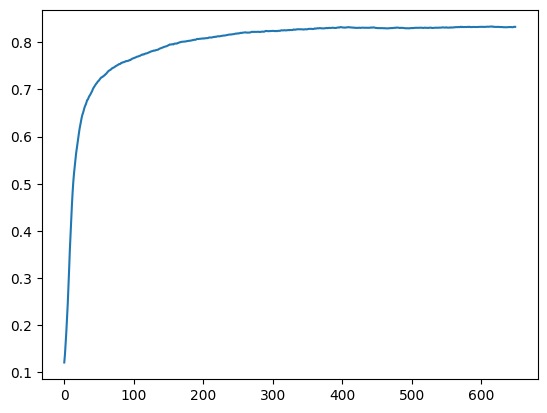

In [ ]:
plt.plot(val_accuracies)


In [12]:
X_test = X_test.reshape(-1, 28*28)
test_out=np.argmax(softmax(sigmoid(X_test.dot(l1)).dot(l2)),axis=1)
test_acc=(test_out==y_test).mean().item()
print(f'Test accuracy = {test_acc*100:.2f}%')
 

Test accuracy = 82.14%


array([1])

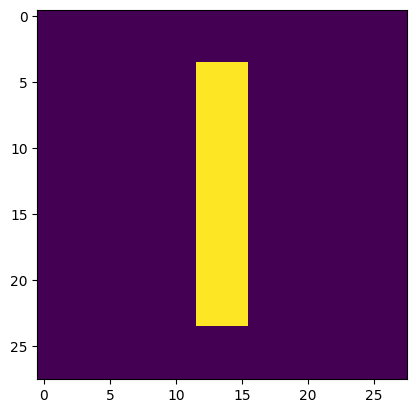

In [70]:
m = [[0,0,0,0,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,0,0,0,0]]

m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
m=m.reshape(1,-1)
plt.imshow(m.reshape(28,28))
x = np.argmax(sigmoid(m.dot(l1)).dot(l2),axis=1)
x

# Saving weights for 1st and 2nd layer. CAREFUL NOT TO CLICK AFTER TRAINING.

In [ ]:
np.savetxt('weights_layer1.csv', l1, delimiter=',')
np.savetxt('weights_layer2.csv', l2, delimiter=',')

Loading weights for 1st and 2nd layer. Restart runtime before executing next cell. Test accuracy should be 83.15%

In [1]:
import pandas as pd
import numpy as np

In [45]:
l1 = pd.read_csv('https://raw.githubusercontent.com/afaale/ML/ML/weights_layer1.csv', sep=',',encoding='ISO-8859–1', header=None)
l2 = pd.read_csv('https://raw.githubusercontent.com/afaale/ML/ML/weights_layer2.csv', sep=',',encoding='ISO-8859–1', header=None)
l1 = np.array(l1)
l2 = np.array(l2)
l1.shape, l2.shape

((784, 128), (128, 10))

Bypassing training.

In [47]:
from keras.datasets import mnist
from matplotlib import pyplot as plt
import keras

In [48]:
(X_train,y_train), (X_test, y_test) = mnist.load_data()

In [49]:
#Validation split
rand = np.arange(60000)
#np.random.shuffle(rand)

train_num = rand[:50000]
val_num = rand[50000:]

X_train, X_val = X_train[train_num], X_train[val_num]
y_train, y_val = y_train[train_num], y_train[val_num]
X_train.shape,X_val.shape,y_test.shape, y_val.shape


((50000, 28, 28), (10000, 28, 28), (10000,), (10000,))

In [50]:
sigmoid = lambda z: 1 / (1+np.e**-z)
dsigmoid = lambda z: sigmoid(z)*(1-sigmoid(z))

In [51]:
#altered softmax e^z/sum_1_k(e^z) for computational efficiency
def softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)

#derivative of softmax
def d_softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)*(1-exp_element/np.sum(exp_element,axis=0))

In [71]:
X_test = X_test.reshape(-1, 28*28)
test_out=np.argmax(softmax(sigmoid(X_test.dot(l1)).dot(l2)),axis=1)
test_acc=(test_out==y_test).mean().item()
print(f'Test accuracy = {test_acc*100:.2f}%')

Test accuracy = 83.15%
